In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
from sklearn import linear_model
#silence future warning message
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# Upload the data 

In [2]:
df = pd.read_csv('sales_train.csv')

In [3]:
df = df.drop(['date'], axis = 1)

In [108]:
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,59,22154,999.00,1.0
1,0,25,2552,899.00,1.0
2,0,25,2552,899.00,-1.0
3,0,25,2554,1709.05,1.0
4,0,25,2555,1099.00,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int64  
 1   shop_id         int64  
 2   item_id         int64  
 3   item_price      float64
 4   item_cnt_day    float64
dtypes: float64(2), int64(3)
memory usage: 112.0 MB


# Feature Engineering

In [109]:
df['total'] = df['item_price'] * df['item_cnt_day']

In [111]:
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,total
0,0,59,22154,999.00,1.0,999.00
1,0,25,2552,899.00,1.0,899.00
2,0,25,2552,899.00,-1.0,-899.00
3,0,25,2554,1709.05,1.0,1709.05
4,0,25,2555,1099.00,1.0,1099.00


In [115]:
df1 = df
df1 = df1.drop(['item_cnt_day','item_price'], axis=1)

In [116]:
df2 = df1.groupby(by = ['date_block_num','shop_id','item_id']).sum()
df2 = df2.reset_index(drop=False)
df2.head()

,date_block_num,shop_id,item_id,total
0,0,0,32,1326.0
1,0,0,33,1041.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,257.0


# Define X and Y 
# Xy Scaler Function 

In [117]:
X = df2.drop(['total'], axis=1)
y = df2['total']

## *Problem starts from here*

In [118]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


class XyScaler(BaseEstimator, TransformerMixin):
    """Standardize a training set of data along with a vector of targets."""

    def __init__(self):
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        
    def fit(self, X, y, *args, **kwargs):
        """Fit the scaler to data and a target vector."""
        self.X_scaler.fit(X)
        self.y_scaler.fit(y.values.reshape(-1, 1))
        return self
    
    def transform(self, X, y, *args, **kwargs):
        """Transform a new set of data and target vector."""
        return (self.X_scaler.transform(X),
                self.y_scaler.transform(y.values.reshape(-1, 1)))

    def inverse_transform(self, X, y, *args, **kwargs):
        """Tranform from a scaled representation back to the original scale."""
        return (self.X_scaler.inverse_transform(X),
                self.y_scaler.inverse_transform(y.values.reshape(-1, 1)))

# Performing Lasso or Ridge 

In [119]:
mdl1 = Lasso(alpha =0.05).fit(X, y)
y_pred = mdl1.predict(X)
mean_squared_error(y, y_pred), r2_score(y, y_pred)

(233754920.32350332, 0.003575541132274318)

# Cross Validation Function 

In [120]:
def cv(X_train, y_train, base_estimator, n_folds, random_seed=154):
    """Estimate the in- and out-of-sample error of a model using cross
    validation.
    
    Parameters
    ----------
    
    X_train: np.array
      Matrix of predictors.
      
    y_train: np.array
      Target array.
      
    base_estimator: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
      
    n_folds: int
      The number of folds in the cross validation.
      
    random_seed: int
      A seed for the random number generator, for repeatability.
    
    Returns
    -------
      
    train_cv_errors, test_cv_errors: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds, random_state=random_seed)
    train_cv_errors, valid_cv_errors = np.empty(n_folds), np.empty(n_folds)

    for idx, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
        # Split into train and test
        X_cv_train, y_cv_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_cv_valid, y_cv_valid = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        # Standardize data, fit on training set, transform training and test.
        scaler = XyScaler()
        scaler.fit(X_cv_train, y_cv_train)
        X_cv_train_std, y_cv_train_std = scaler.transform(X_cv_train, y_cv_train)
        X_cv_valid_std, y_cv_valid_std = scaler.transform(X_cv_valid, y_cv_valid)

        # Fit ridge regression to training data.
        mdl = clone(base_estimator)
        mdl.fit(X_cv_train_std, y_cv_train_std)

        # Make predictions.
        y_cv_train_pred = mdl.predict(X_cv_train_std)
        y_cv_valid_pred = mdl.predict(X_cv_valid_std)

        # Calculate MSE.
        train_cv_errors[idx] = mean_squared_error(y_cv_train_std, y_cv_train_pred)
        valid_cv_errors[idx] = mean_squared_error(y_cv_valid_std, y_cv_valid_pred)
    return train_cv_errors, valid_cv_errors

In [121]:
train_cv_errors, valid_cv_errors = cv(X, y, base_estimator=Ridge(alpha=0.5), n_folds=5, random_seed=154)

In [122]:
print(f"Training CV error: {train_cv_errors.mean():.2f}")
print(f"Test CV error: {valid_cv_errors.mean():.2f}")

Training CV error: 1.00
Test CV error: 1.07


# Optimal ALpha Function 

In [123]:
def train_at_various_alphas(X_train, y_train, model, alphas, n_folds, random_seed, **kwargs):
    """Train a regularized regression model using cross validation at various
    values of alpha.
    
    Parameters
    ----------
    
    X_train: np.array
      Matrix of predictors.
      
    y_train: np.array
      Target array.
      
    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are `Ridge` and `Lasso`.
      
    alphas: numpy array
      An array of regularization parameters.
      
    n_folds: int
      Number of cross validation folds.
      
    Returns
    -------
    
    cv_errors_train, cv_errors_valid: tuple of DataFrame
      DataFrames containing the training and validating errors for each value of
      alpha and each cross validation fold.  Each row represents a CV fold, and
      each column a value of alpha.
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_valid = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_cv_errors, valid_cv_errors = cv(X_train, y_train, base_estimator=model(alpha=alpha, **kwargs), n_folds=n_folds, random_seed=random_seed)
        cv_errors_train.loc[:,alpha] = train_cv_errors
        cv_errors_valid.loc[:,alpha] = valid_cv_errors
    return cv_errors_train, cv_errors_valid

In [129]:
alphas=np.logspace(-4,-1, num=50)
cv_errors_train, cv_errors_valid = train_at_various_alphas(X, y, model=Lasso, alphas=alphas, n_folds=5, random_seed=154)

In [130]:
train_means, valid_means = cv_errors_train.mean(axis=0), cv_errors_valid.mean(axis=0)

In [131]:
alphas = valid_means.index
optimal_idx = np.argmin(valid_means.values)
optimal_alpha = alphas[optimal_idx]


0.003906939937054617

In [132]:
#method 2:
optimal_alpha = valid_means.idxmin()
optimal_alpha

0.003906939937054617

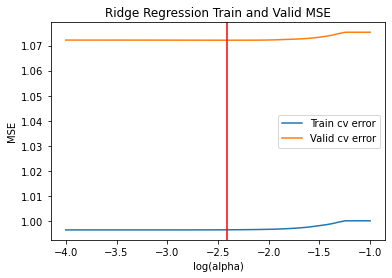

In [133]:
fig, ax = plt.subplots()
ax.plot(np.log10(alphas), train_means, label='Train cv error')
ax.plot(np.log10(alphas), valid_means, label='Valid cv error')
ax.axvline(np.log10(valid_means.idxmin()), color='red')
ax.legend()
ax.set_title('Ridge Regression Train and Valid MSE')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('MSE');

# Trying the formula Swathi gave us 

In [136]:
from sklearn.linear_model import LassoLarsIC
clf = LassoLarsIC()
clf.fit(X, y)
y_hat = clf.predict(X)
clf.alpha_

0.0

In [67]:
# build a list of fitted models
models = []
for alpha in alphas:
    scaler = XyScaler()
    scaler.fit(X, y)
    X_train_std, y_train_std = scaler.transform(X, y)
    model = Ridge(alpha=alpha)
    model.fit(X_train_std, y_train_std)
    models.append(model)

ValueError: x and y must have same first dimension, but have shapes (50,) and (1586,)

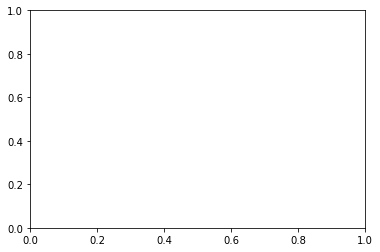

In [70]:
fig, ax = plt.subplots()
for col in ['date_block_num','shop_id']:
    path = df2.loc[:, col] # each col of df corresponds to each path (across diff alphas)
    ax.plot(np.log10(alphas), path, label=col)
ax.axvline(np.log10(optimal_alpha), color='red')
ax.legend()
ax.set_title('Ridge Regression, Standarized Coefficient Paths')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Standarized Coefficient');